In [1]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid

from matplotlib.pyplot import rcParams
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize


from arch import arch_model
from tqdm import tqdm_notebook
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

figsize=(17, 8)

rcParams['figure.figsize'] = figsize

In [6]:
data = pd.read_csv('../toy_dataset.csv')
data['observation_date'] = pd.to_datetime(data['observation_date'])
data.columns = ['time', 'value']
predictor = 'value'
d = data.copy()

In [4]:
split_coeff = 0.66
X = data[predictor]

### Helper functions

In [25]:
def autocorrelation_plot_it(x, plot=True):
    n = len(x)
    variance = x.var()
    x = x - x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1))) * (n - np.arange(0,n))/ n  # correction
    inter = 1.96 / np.sqrt(n)
    if plot:
        with plt.style.context('bmh'):
            plt.figure(figsize=figsize)
            plt.plot(result, lw=2.5)
            plt.axhline(0, c='black', alpha=.4)

            plt.axhline(inter, c='red', alpha=.7, ls='--')
            plt.axhline(-inter, c='red', alpha=.7, ls='--')

            plt.ylim(-1,1)
            plt.xlim(1, n)
            plt.xlabel('Lag')
            plt.ylabel('Autocorrelation')
            plt.tight_layout()
    return result


def autocorrelation_analysis(x, tre=.9):
    """
        Analysis of time series
            x   -- Series
            tre -- periodic treshold
        Return:
            isPeriodic -- bool periodic/not periodic
            lags_pop   -- most probable lags
    """
    n = len(x)
    isPeriodic =False
    x = pd.Series(x)
    first_diff = x.diff().dropna()
    auto = autocorrelation_plot_it(first_diff, plot=False)
    l = 1.96 / np.sqrt(n)
    
    percentage = auto[np.where(auto > -l) and np.where(auto < l)].shape[0] / n
    
    if percentage >= tre:
#         print('The time series is probably not periodic.')
        isPeriodic = False
    if percentage < tre:
#         print('The time series is probably periodic or having a trend')
        isPeriodic = True
    
    auto_fixed = auto[1:]  # не учитывая корреляцию с самим собой
    lags_pop = np.argsort(auto_fixed)[-2:]
    
#     print('Most probable lags are: {0}. Corresponding correlations: {1}'.format(lags_pop + 1, auto_fixed[lags_pop]))
    
    return isPeriodic, lags_pop
    



# smoothers

def timeseriesCVscoreWinters(x):

    errors = []

    alpha, beta, gamma = x
    values = data[predictor].values
    isSeasonal, lags = autocorrelation_analysis(values)
    if isSeasonal:
        seasonal_periods = lags[-1]
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        train_data = np.asarray(pd.Series(values[train]).dropna())
        if isSeasonal:
            fit_it = ExponentialSmoothing(train_data, seasonal_periods=seasonal_periods).fit(smoothing_level=alpha,
                                                      smoothing_slope=beta,
                                                      smoothing_seasonal=gamma)
        else:
            fit_it = ExponentialSmoothing(train_data).fit(smoothing_level=alpha,
                                                      smoothing_slope=beta,
                                                      smoothing_seasonal=gamma)
        test_data = np.asarray(pd.Series(values[-len(test):]).dropna())
        predictions = fit_it.forecast(len(test))
        actual = values[test]

        error = np.sqrt(mean_squared_error(actual, predictions))

        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок
    return np.mean(np.array(errors)) 



def timeseriesCVscoreHolt(x):
    errors = []

    alpha, beta = x
    values = data[predictor].values

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        train_data = np.asarray(pd.Series(values[train]).dropna())

        fit_it = Holt(train_data).fit(smoothing_level=alpha,
                                      smoothing_slope=beta,)

        test_data = np.asarray(pd.Series(values[-len(test):]).dropna())
        predictions = fit_it.forecast(len(test))
        actual = values[test]

        error = np.sqrt(mean_squared_error(actual, predictions))

        errors.append(error)
    
    return np.array(errors).mean()
def timeseriesCVscoreExpSmoothing(x):
    errors = []

    alpha = x
    values = data[predictor].values

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        train_data = np.asarray(pd.Series(values[train]).dropna())

        fit_it = SimpleExpSmoothing(train_data).fit(smoothing_level=alpha)

        test_data = np.asarray(pd.Series(values[-len(test):]).dropna())
        predictions = fit_it.forecast(len(test))
        actual = values[test]

        error = np.sqrt(mean_squared_error(actual, predictions))

        errors.append(error)
        
    return np.array(errors).mean()

def search_optimal(algo='winters'):
    if algo == 'winters':
        x = [0.5, 0.5, 0.5]
        opt = minimize(timeseriesCVscoreWinters, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))
        alpha_final, beta_final, gamma_final = opt.x
        return opt.fun, opt.x
    
    elif algo == 'holt':
        x = [0.5, 0.5] 
        opt = minimize(timeseriesCVscoreHolt, x0=x, method="TNC", bounds = ((0, 1), (0, 1)))
        alpha_final, beta_final = opt.x
        return opt.fun, opt.x
    elif algo == 'smoothing':
        x = [0.5]
        opt = minimize(timeseriesCVscoreExpSmoothing, x0=x, method="TNC", bounds=((0,1),))
        return opt.fun, opt.x
#######

# ARIMA
    
def gridsearch(dataset):
    """
        dataset -- series
    """
    X = dataset.copy()

    best_aic = float("inf")
    isSeasonal, lags = autocorrelation_analysis(dataset)
    if isSeasonal:
        param_grid = {'p':[lags[-1] + 1],
                    'q':[i for i in range(5)],
                     'd':[1, 2]}
    else:
        param_grid = {'p':[1,2,5,7],
                    'q':[i for i in range(5)],
                     'd':[1, 2]}
    grid = ParameterGrid(param_grid)

    index=0

    for params in tqdm_notebook(grid, total=len(grid)):
        try:
            model = ARIMA(X, order=(params['p'],
                                     params['d'],
                                     params['q'])).fit()
        except Exception as e:
            print('Wrong parameters. Not invertible: ', params)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = params

        index+=1
    return best_model, best_param

def arima(dataset, split=0.66, plot=False):
    variance = np.var(dataset)
    mean_value = np.mean(dataset)
    X_scaled = (dataset - mean_value) / variance
    print('Searching for optimal parameters: p,q,d...\n')
    model, param = gridsearch(X_scaled)
    print('Best params: ', param)
    
    idx = int(len(X_scaled) * split)
    train, test = X_scaled.iloc[:idx], X_scaled.iloc[idx:]
    best_model = ARIMA(train, order=(param['p'], param['d'], param['q'])).fit(disp=0)
    preds = best_model.predict(idx, len(dataset)-1)
    
    preds_inv_normed = preds * variance + mean_value
    error = np.sqrt(mean_squared_error(test, preds))
    
    if plot:
        plt.title('ARIMA\nRMSE: %.3f'%error)
        plt.plot(dataset[:idx], label='Train')
        plt.plot(dataset[idx:],  label='Test')
        plt.plot(preds_inv_normed,  label='ARIMA')
        plt.legend()
        plt.subplots_adjust(top=2.)
    return preds_inv_normed, error

#####

# GARCH

def garch_model(dataset, b_params=None, splitter=0.66):
    variance, mean_value = dataset.var(), dataset.mean()
    n = len(dataset)
    
    X_scaled  = (dataset - mean_value) / variance
    
    if b_params is not None:
        p, o, q = b_params['p'], b_params['d'], b_params['q']
    else:
        _, param = gridsearch(X_scaled)
        p, o, q = param['p'], param['d'], param['q']
    # train-test split
    idx = int(n * splitter)
    train, test = X_scaled[:idx], X_scaled[idx:]
    # train model
    am = arch_model(train, p=p, o=o, q=q, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    # prediction
    forecast = res.forecast(horizon=n-idx)
    preds = forecast.variance.values[-1,:]
    preds = pd.DataFrame(preds, index=test.index)
    error = np.sqrt(mean_squared_error(preds, test))
    
    preds_inv_normed = preds * variance + mean_value
    return error, preds_inv_normed

#######

# MAKE IT WORK TOGETHER

def smoother_gs(series):
    """
        Find optimal params for smoothing methods
    """
    algos = ['winters', 'holt', 'smoothing']
    errors, args = [], []
    for alg in algos:
        er, prm = search_optimal(algo=alg)
        errors.append(er)
        args.append(prm)
    return errors, args

def get_smoothers(series, args):
    """
        Get smoothers with the best params
    """
    args_winters, args_holt, args_smooth = args[0], args[1], args[2]
    
    # Holt-Winters    
    isSeasonal, lags = autocorrelation_analysis(series)
    if isSeasonal:
        seasonal_periods = lags[-1]
        fit_holt_winters = ExponentialSmoothing(np.asarray(pd.Series(series).dropna()), 
                                                seasonal_periods=seasonal_periods).fit(args_winters[0],
                                                                                        args_winters[1],
                                                                                        args_winters[-1])
    else:
        fit_holt_winters = ExponentialSmoothing(np.asarray(pd.Series(series).dropna())).fit(args_winters[0],
                                                                                        args_winters[1],
                                                                                        args_winters[-1])
        
    # Holt
    fit_holt = Holt(np.asarray(pd.Series(series).dropna())).fit(args_holt[0], 
                                                                 args_holt[1])
    
    # ExpSmoother
    fit_exp_smoother = SimpleExpSmoothing(np.asarray(pd.Series(data[predictor]).dropna())).fit(args_smooth)
    
    fitted_models = {
        'holt':fit_holt,
        'winters':fit_holt_winters,
        'smooting':fit_exp_smoother
    }
    return fitted_models

def fit_smoothers(series, splitter=.66, plot=False):
    """
        Method for training and comparing the models
            1. Exponential smoothing
            2. Holt method
            3. Holt-Winters method
        Arguments:
            -- series - Series object, timeseries to forecast
            -- splitter - train-test-split in percentage(default = 0.66)
        Returns:
            -- models_results - dictionary with the meaning of the perfomance metric on the test set
            -- models_preds - dictionary with predictions for each model(will be used in plot method)
    """
    n = len(series)
    idx = int(n * splitter)
    train = series[:idx]
    test = series[idx:]
    
    def plot_(p, title, label, number):
        plt.subplot(number)
        plt.title(title)
        plt.plot(train, label='Train')
        plt.plot(test, label='Test')
        plt.plot(p, label=label)
        plt.legend()
        plt.subplots_adjust(top=2)
    
    test_len = len(test)
    
    # get smoothers fitted object
    _, args = smoother_gs(train)
    
    models = get_smoothers(train, args)
    models_results = {}
    
    # for plotting
    models_preds = {}
    num = 311
    for key, model in tqdm_notebook(models.items(), total = len(models)):
        pred = model.forecast(test_len)
        pred = pd.DataFrame(pred, index=test.index)
        rmse = np.sqrt(mean_squared_error(pred, test))
        if plot:
            plot_(pred, str.upper(key) + '\nRMSE: %.4f'%rmse, str.upper(key), num)
        
        models_results[key] = rmse
        models_preds[key] = pred
        num += 1
    return models_results, models_preds

def arima(dataset, splitter=0.66):
    """
        ARIMA model
        Arguments:
            -- dataset - Series object with series for forecasting
            -- splitter - train-test-split coefficient
        Returns:
            -- param - parameters found optimal for ARIMA
            -- error - float value of RMSE on test data
            -- preds_inv_normed -- vector with predictions
    """
    variance = np.var(dataset)
    mean_value = np.mean(dataset)
    X_scaled = (dataset - mean_value) / variance
    print('Searching for optimal parameters: p,q,d...\n')
    model, param = gridsearch(X_scaled)
    print('Best params: ', param)
    
    idx = int(len(X_scaled) * splitter)
    train, test = X_scaled.iloc[:idx], X_scaled.iloc[idx:]
    best_model = ARIMA(train, order=(param['p'], param['d'], param['q'])).fit(disp=0)
    preds = best_model.predict(idx, len(dataset)-1)
    
    preds_inv_normed = preds * variance + mean_value
    error = np.sqrt(mean_squared_error(test, preds))
    return param, preds_inv_normed, error

def garch_model(dataset, b_params=None, splitter=0.66):
    """
        GARCH model
        
        Arguments:
            -- dataset - Series object with series for forecasting
            -- b_params - dictionary with values of hyperparameters (p, d, q) from ARIMA, 
                            if None, b_params will be searched from training the ARIMA.
            -- splitter - train-test-split coefficient
        Returns:
            -- error - float value of RMSE on test data
            -- preds_inv_normed -- vector with predictions
    """
    
    
    variance, mean_value = dataset.var(), dataset.mean()
    n = len(dataset)
    
    X_scaled  = (dataset - mean_value) / variance
    
    if b_params is not None:
        p, o, q = b_params['p'], b_params['d'], b_params['q']
    else:
        _, param = gridsearch(X_scaled)
        p, o, q = param['p'], param['d'], param['q']
    # train-test split
    idx = int(n * splitter)
    train, test = X_scaled[:idx], X_scaled[idx:]
    # train model
    am = arch_model(train, p=p, o=o, q=q, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    # prediction
    forecast = res.forecast(horizon=n-idx)
    preds = forecast.variance.values[-1,:]
    preds = pd.DataFrame(preds, index=test.index)
    error = np.sqrt(mean_squared_error(preds, test))
    
    preds_inv_normed = preds * variance + mean_value
    return preds_inv_normed, error

def fit_complex(dataset, splitter=.66):
    best_params, arima_preds, error_arima = arima(dataset, splitter=splitter)
    garch_preds, error_garch = garch_model(dataset, b_params=best_params, splitter=splitter)
    results = {
        'garch_preds':garch_preds,
        'error_garch':error_garch,
        'arima_preds':arima_preds,
        'error_arima':error_arima
    }
    return results

def fit(dataset, splitter=.66, plot=False):
    """
        Fit method for smoothers and ARIMA, GARCH models. Comparing the models, selecting the best and plotting
        Returns:
            smooth_errors -- dictionary with perfomance metrics
            smooth_preds -- dictionary with predictions
            complex_results -- dictionary with perf metrics and predictions for ARIMA, GARCH
    """
    smooth_errors, smooth_preds = fit_smoothers(dataset, splitter=splitter, plot=plot)
    complex_results = fit_complex(dataset, splitter=splitter)
    errors = smooth_errors
    garch_error, arima_error = complex_results['error_garch'], complex_results['error_arima']
    errors['garch'] = garch_error
    errors['arima'] = arima_error
#     errors = sorted(errors.items(), lambda x: x[1])
#     print('Best model: %s, rmse: %.3f'%(errors[-1][0], errors[-1][1]))
    return errors, smooth_preds, complex_results

### Fitting the models

#### Using helper functions, we can choose to fit different models independently, for example smoother functions

A Jupyter Widget

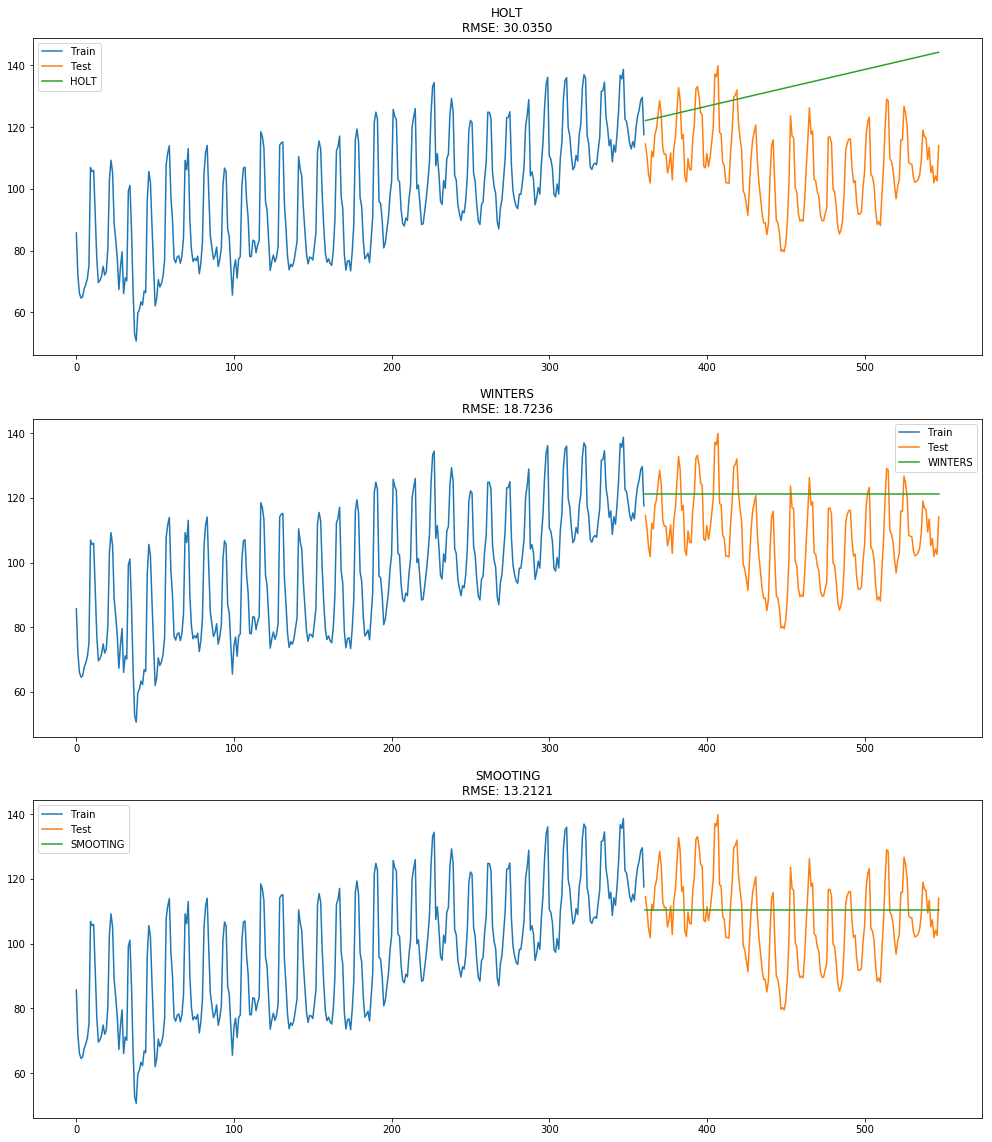

In [13]:
res, pr = fit_smoothers(X, plot=True)

#### ARIMA, GARCH

In [26]:
res = fit_complex(X)

Searching for optimal parameters: p,q,d...



A Jupyter Widget

/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params av

Wrong parameters. Not invertible:  {'d': 2, 'p': 12, 'q': 4}

Best params:  {'d': 1, 'p': 12, 'q': 3}


/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


#### Fitting all methods and comparing the results

A Jupyter Widget


Searching for optimal parameters: p,q,d...



A Jupyter Widget

/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or co

Wrong parameters. Not invertible:  {'d': 2, 'p': 12, 'q': 2}


/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Wrong parameters. Not invertible:  {'d': 2, 'p': 12, 'q': 4}

Best params:  {'d': 1, 'p': 12, 'q': 3}


/Users/Vlad/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Vlad/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


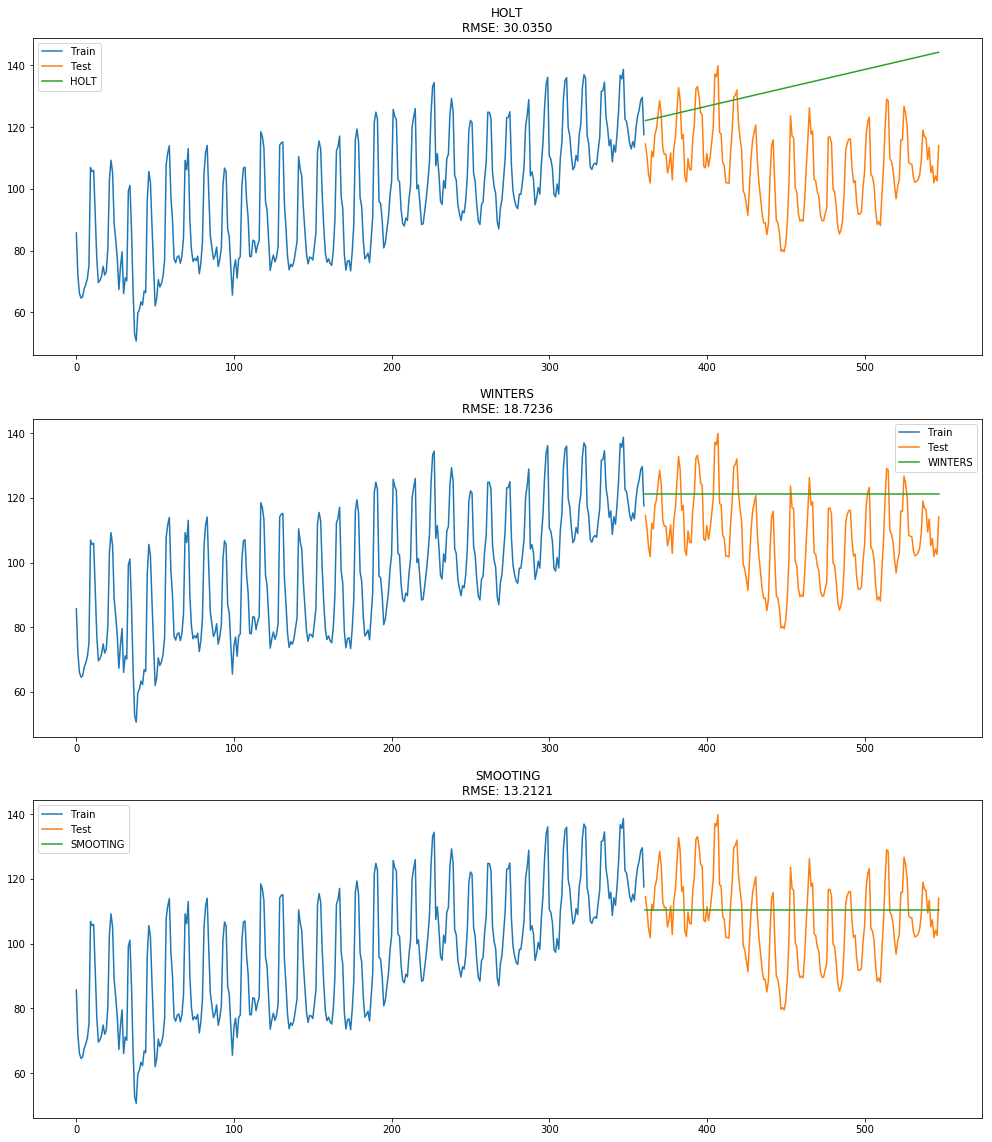

In [27]:
err, smooth_pred_values, complex_pred_values = fit(X, plot=True)

### Plot the results for ARIMA and GARCH

In [29]:
complex_pred_values.keys()

dict_keys(['garch_preds', 'error_garch', 'arima_preds', 'error_arima'])

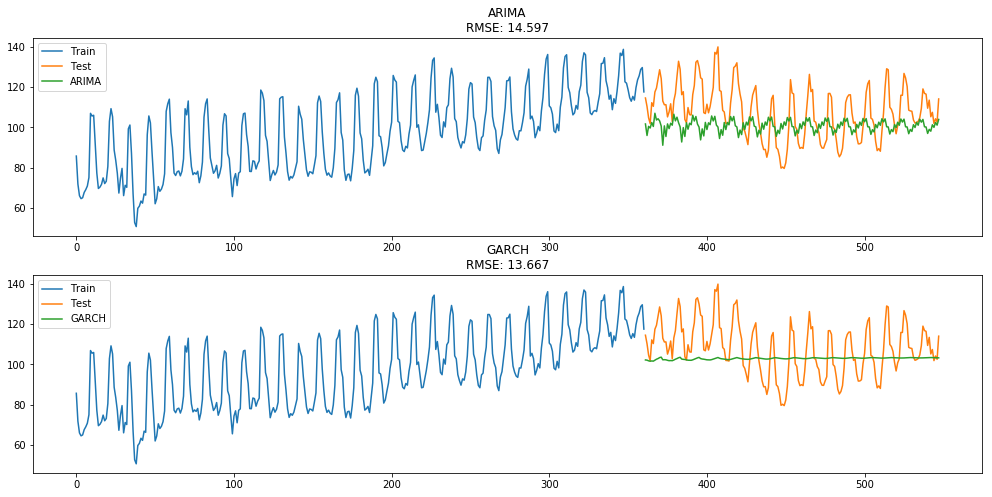

In [43]:
tr = X[:int(len(X) * split_coeff)]
test = X[int(len(X) * split_coeff):]
plt.subplot(211)
plt.title('ARIMA\nRMSE: %.3f'%np.sqrt(mean_squared_error(test, complex_pred_values['arima_preds'])))
plt.plot(tr, label='Train')
plt.plot(test, label='Test')
plt.plot(complex_pred_values['arima_preds'], label='ARIMA');
plt.legend();
plt.subplot(212)
plt.title('GARCH\nRMSE: %.3f'%np.sqrt(mean_squared_error(test, complex_pred_values['garch_preds'])))
plt.plot(tr, label='Train')
plt.plot(test, label='Test')
plt.plot(complex_pred_values['garch_preds'], label='GARCH');
plt.legend();

## So, we can see that for this task, it is better to choose exponential smoothing or GARCH